In [1]:
from datasets import keepcontrol
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Global variables
PATH = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata"
DEMOGRAPHICS_FILE = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/participants.tsv"
TRACKED_POINTS = ["left_ankle", "right_ankle"]
CLASSIFICATION_TASK = "events"
WIN_LEN = 400

In [3]:
ds_train, ds_val, ds_test = keepcontrol.load_data(
    path=PATH,
    filename=DEMOGRAPHICS_FILE,
    tracked_points=TRACKED_POINTS,
    incl_magn=False,
    classification_task=CLASSIFICATION_TASK,
    win_len=WIN_LEN
)

Load dataset from pickle ...


In [4]:
# Split datasets in data and labels
(train_data, train_labels, train_filenames, train_ids) = ds_train
(val_data, val_labels, val_filenames, val_ids) = ds_val

In [7]:
val_filenames[0]

'sub-pp047_task-walkFast_events.tsv'

In [8]:
indx_examples = [indx for indx in range(len(val_filenames)) if val_filenames[indx]==val_filenames[0]]
print(indx_examples)

[0, 1]


In [9]:
omc_filename = val_filenames[0].replace("_events.tsv", "_tracksys-omc_motion.tsv")
imu_filename = val_filenames[0].replace("_events.tsv", "_tracksys-imu_motion.tsv")

In [10]:
df_events = pd.read_csv(os.path.join(PATH, val_filenames[0][:9], "motion", val_filenames[0]), sep="\t", header=0)
df_omc = pd.read_csv(os.path.join(PATH, val_filenames[0][:9], "motion", omc_filename), sep="\t", header=0)
df_imu = pd.read_csv(os.path.join(PATH, val_filenames[0][:9], "motion", imu_filename), sep="\t", header=0)

In [11]:
df_events.head()

,onset,duration,event_type
0,305,0,final_contact_right
1,367,0,start
2,382,0,initial_contact_right
3,406,0,final_contact_left
4,488,0,initial_contact_left


In [12]:
indx_start = df_events[df_events["event_type"]=="start"]["onset"].values[0]-1
indx_stop = df_events[df_events["event_type"]=="stop"]["onset"].values[0]

In [13]:
data = df_imu[[col for col in df_imu.columns if ("left_ankle" in col) and ("MAGN" not in col)]].to_numpy()
data.shape

(1162, 6)

In [14]:
mn = np.mean(data, axis=0)
sd = np.std(data, axis=0)
# np.tile(np.expand_dims(mn, axis=0), (data.shape[0], 1))[:3,:]
normalized_data = (data - np.tile(np.expand_dims(mn, axis=0), (data.shape[0], 1))) / np.tile(np.expand_dims(sd, axis=0), (data.shape[0], 1))

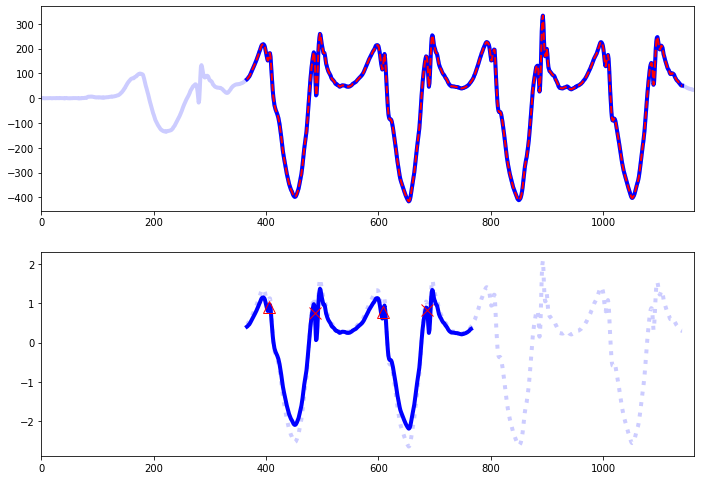

In [27]:
cm = 1/2.54
fig, axs = plt.subplots(2, 1, figsize=(29.7*cm, 21*cm))
axs[0].plot(np.arange(len(df_imu)), df_imu["left_ankle_ANGVEL_z"], ls="-", c=(0, 0, 1, 0.2), lw=4)
axs[0].plot(np.arange(indx_start, indx_stop), df_imu["left_ankle_ANGVEL_z"].iloc[indx_start:indx_stop], ls="-", c=(0, 0, 1), lw=4)
axs[0].plot(np.arange(indx_start, indx_stop), data[indx_start:indx_stop,5], ls="--", c=(1, 0, 0), lw=2)
axs[0].set_xlim((0, len(df_imu)))

axs[1].plot(np.arange(indx_start, indx_stop), normalized_data[indx_start:indx_stop,5], ls=":", c=(0, 0, 1, 0.2), lw=4)
axs[1].plot(np.arange(indx_start, indx_start+WIN_LEN), val_data[0][:,5], ls="-", c=(0, 0, 1), lw=4)
axs[1].plot(indx_start+np.argwhere(val_labels[0][:,1]==1.0)[:,0], val_data[0][np.argwhere(val_labels[0][:,1]==1.0)[:,0],5], ls="none", marker="^", mec="r", mfc="none", ms=12)
axs[1].plot(indx_start+np.argwhere(val_labels[0][:,0]==1.0)[:,0], val_data[0][np.argwhere(val_labels[0][:,0]==1.0)[:,0],5], ls="none", marker="x", mec="r", ms=12)
axs[1].set_xlim((0, len(df_imu)))
plt.show()

In [23]:
ixs = np.argwhere(val_labels[0][:,0]==1.0)[:,0]
print(ixs)

[121 321]
